# <span style="color:Black"><center>Diplomado en Inteligencia Artificial y Aprendizaje Profundo</center></span>

## <span style="color:purple"><center>Predicción del valor de una acción a quince días. Apple (LSTM)</center></span>

### <span style="color: black">Realizado por:</span>
### <span style="color: purple">Andrés Felipe Nieto Grandas</span>
<br>

## <span style="color:black">Importar las librería requeridas</span>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler

# importa objetos de keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU
print("Versión de Tensorflow: ", tf.__version__)

import math

# optimizador
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD

Versión de Tensorflow:  2.4.1


## <span style="color:purple">Lectura de  los datos</span>

Estos datos corresponden a la empresa *Tata Global Beverages*. Son  1235 datos que corresponden a observaciones del precio de la acción, el número de transacciones de la acción (compra-venta). Los datos son diarios (dias hábiles o comerciales). Están entre el 8 de octubre de 2013 hasta el 8 de octubre de 2018.

la columna *Date* es la fecha, *Open* es el valor de acción a la apertura del mercado, *High* el valor más alto alcanzado en el día, *Low* el valor más bajo del día, *Close* el valor al cierre, *Total_Trade_Quantity* el total de acciones transadas y *Turnover_Lacs* índice de rotación.

In [2]:
#Cargamos el dataset
df = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv')


In [3]:
# observamos como viene organizada la data
print('\n Shape of the data:')
print(df.shape)
df.head()


 Shape of the data:
(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


Vamos a cambiar el índice de los datos. Tomaremos la fecha como indice: *df.index*. Los datos se reordenan para invertir la tabla, debido a que los datos contienen las observaciones más recientes en la parte superior de la tabla.

## <span style="color:purple">Extrae datos para la serie que se desea predecir-close</span>

In [4]:
#creating dataframe with date and the target variable

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
data = pd.DataFrame(df[['Date', 'Close']])

#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


## <span style="color:purple">Visualización de la serie precio al cierre</span>


In [5]:
# plot
len_data = len(data)
len_train = int(len_data*0.8) # 80%  = 3019
len_test = len_data- len_train # 20% = 2415
print (len_data, '=', len_train, '+',len_test)

3019 = 2415 + 604


## <span style="color:purple">Grafica Historioa del precio de la acción</span>

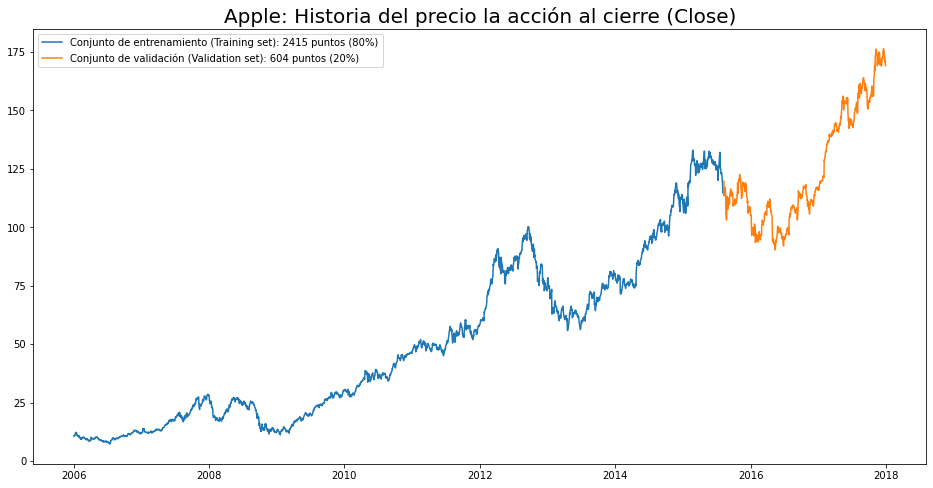

In [6]:
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test)) #248 data
plt.title("Apple: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

## <span style="color:purple">Preparación de los datos para el entrenamiento de la red GRU</span>

Para evitar problemas con las tendencias y para mejorar la estimación (entrenamiento) los datos se van a transformar a la escala $[0,1]$. Para las predicciones se utiliza la transformación inversa.

### Primero extrae los valores y se crea el  objeto MinMaxScaler

In [69]:
#creating train and test sets
dataset = data.values

# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [70]:
dataset.shape

(3019, 1)

## <span style="color:purple">Procedemos a preparar los datos de entrenamiento</span>

In [71]:
# Longitud de las tiras de datos para hacer las predicciones
time_step = 60
# días hasta predecir
days = 3
#
# crea datos de entrenamiento
x_train, y_train = [], []
#
for i in range(time_step ,len_train ):
    # x: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    x_train.append(scaled_data[i-time_step :i,0])
    # y: el siguiente dato
    y_train.append(scaled_data[i+days,0])
x_train, y_train = np.array(x_train), np.array(y_train)
#
#
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
#
print(x_train.shape)
print(y_train.shape)



(2355, 60, 1)
(2355, 1)


## <span style="color:purple">Crea el modelo GRU</span>

#### Usaremos este modelo para entrenar la red 15 dias

In [72]:
input_shape = (x_train.shape[1],1)

# Arquitectura GRU
model = Sequential()

# Primera capa GRU con Dropout de regularización
model.add(GRU(units=50, return_sequences=True, input_shape=input_shape, activation='tanh'))
model.add(Dropout(0.2))
# Segunda capa GRU
model.add(GRU(units=50, return_sequences=True, input_shape=input_shape, activation='tanh'))
model.add(Dropout(0.2))
# Tercera capa GRU
model.add(GRU(units=50, return_sequences=True, input_shape=input_shape, activation='tanh'))
model.add(Dropout(0.2))
# Cuarta capa GRU
model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))
# Capa de salida
model.add(Dense(units=1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 60, 50)            7950      
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
gru_13 (GRU)                 (None, 60, 50)            15300     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
gru_14 (GRU)                 (None, 60, 50)            15300     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
gru_15 (GRU)                 (None, 50)               

## <span style="color:purple">Crea el modelo GRU</span>

#### e usará el optimizador SGD y la función de pérdida MSE

In [73]:
# Compiling the 
model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')


## <span style="color:purple">Entrenamiento</span>

In [74]:
# Fitting to the training set
history = model.fit(X_train,y_train,validation_split=0.1, epochs=30, batch_size=100)

Epoch 1/30
22/22 [==============================] - 13s 260ms/step - loss: 0.0453 - val_loss: 0.0818
Epoch 2/30
22/22 [==============================] - 4s 162ms/step - loss: 0.0157 - val_loss: 0.0591
Epoch 3/30
22/22 [==============================] - 3s 159ms/step - loss: 0.0057 - val_loss: 0.0101
Epoch 4/30
22/22 [==============================] - 3s 153ms/step - loss: 0.0015 - val_loss: 8.7055e-04
Epoch 5/30
22/22 [==============================] - 3s 154ms/step - loss: 0.0012 - val_loss: 6.5141e-04
Epoch 6/30
22/22 [==============================] - 4s 162ms/step - loss: 0.0010 - val_loss: 7.8792e-04
Epoch 7/30
22/22 [==============================] - 3s 155ms/step - loss: 8.7585e-04 - val_loss: 9.2851e-04
Epoch 8/30
22/22 [==============================] - 3s 155ms/step - loss: 9.8218e-04 - val_loss: 9.6097e-04
Epoch 9/30
22/22 [==============================] - 3s 155ms/step - loss: 0.0011 - val_loss: 7.2774e-04
Epoch 10/30
22/22 [==============================] - 3s 154ms/step 

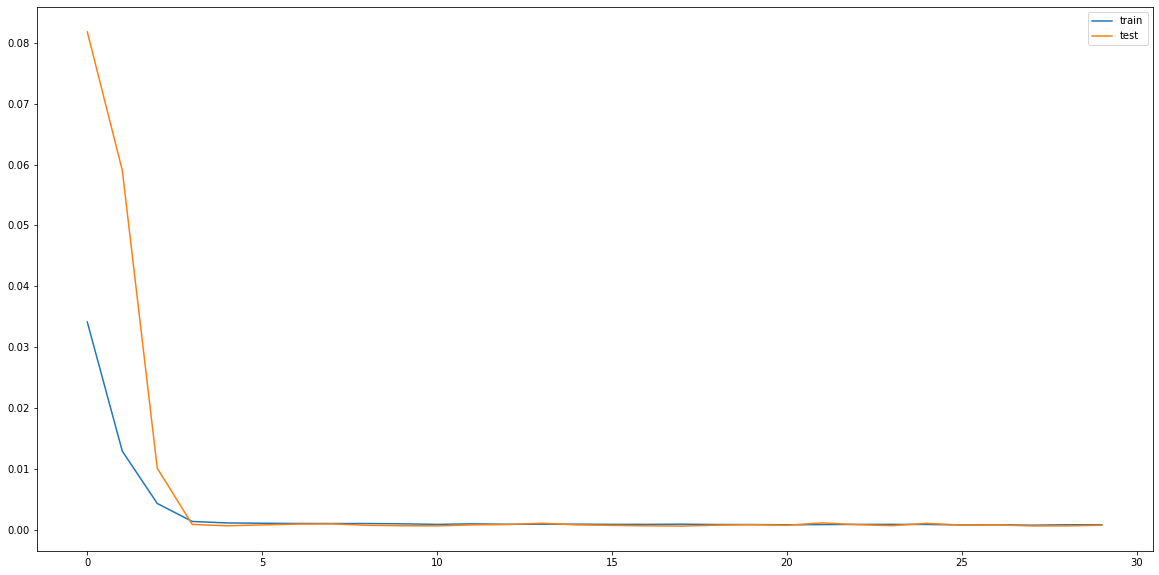

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## <span style="color:purple">Predicciones</span>

### Se prepara el conjunto para testear el modelo

In [79]:
inputs = data[len_data - len_test - time_step:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_test = []
y_test = []

# aqui vamos

for i in range(time_step,inputs.shape[0]):
    x_test.append(inputs[i-time_step:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


In [80]:
# predictions
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

In [82]:
print(prediction.shape)

(604, 1)


## <span style="color:purple">Grafica que muestra un comparativo entre el valor real de la acción y su predicción</span>

In [94]:
# Funciones auxiliares
#
def plot_prediction(real, prediccion):
    plt.plot(real,color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()


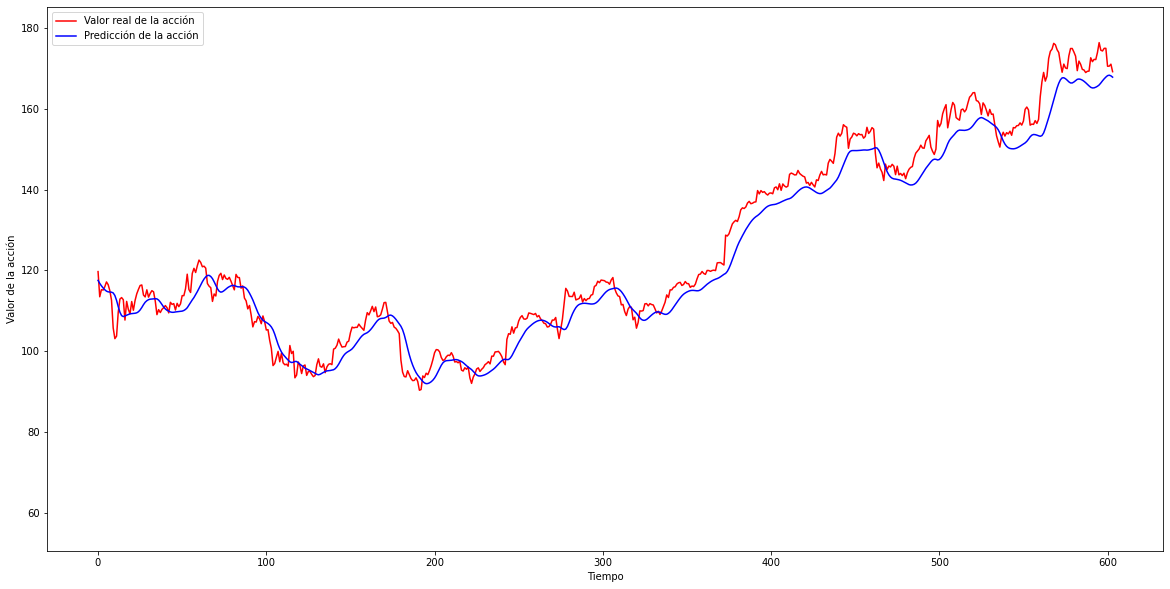

In [95]:
set_validation = data[len_data - len_test :].values
plot_prediction(set_validation ,prediction)

## Regreso a la escala original

In [65]:
y_pred_or = scaler.inverse_transform(y_pred_p.reshape(-1,1))
y_test_or = scaler.inverse_transform(y_test_p.reshape(-1,1))

In [91]:
train = pd.DataFrame(data[:len_train])
valid = pd.DataFrame(data[len_train:])
valid['Predictions'] = prediction


In [92]:
np.sqrt(np.mean(np.power(valid['Close'].values-valid['Predictions'].values,2)))
rmsGRU = np.sqrt(np.mean(np.power(valid['Close'].values-valid['Predictions'].values,2)))
rmsGRU 

4.5643838369888

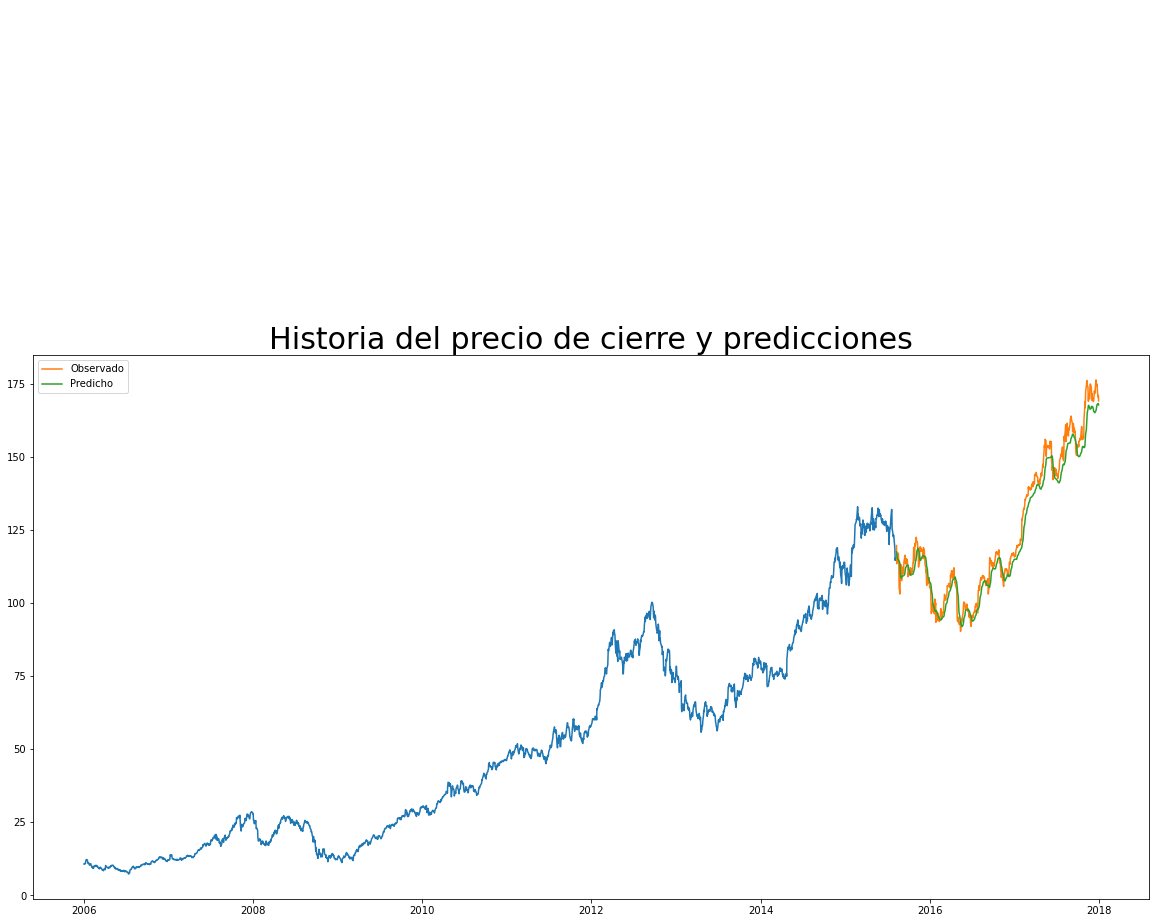

In [96]:
rmsLSTM = np.sqrt(np.mean(np.power(valid['Close'].values-valid['Predictions'].values,2)))

train = pd.DataFrame(data[:len_train])
valid = pd.DataFrame(data[len_train:])

valid['Predictions'] = prediction
plt.plot(train['Close'])
plot = plt.plot(valid[['Close','Predictions']])
plt.annotate("rms = "+str(rmsLSTM) , xy=(data.index[1],300), size = 15)
plt.legend(plot, ("Observado","Predicho"))
plt.title("Historia del precio de cierre y predicciones", size = 30)
plt.show()

## <span style="color:blue">Guarda el modelo entrenado</span>

In [102]:
model.save('../Datos/modelo_Apple_15_dias.h5')

## <span style="color:blue">Intervalos de confianza. TO DO</span>

In [100]:
model.get_config()

{'name': 'sequential_3',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 60, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'gru_12_input'}},
  {'class_name': 'GRU',
   'config': {'name': 'gru_12',
    'trainable': True,
    'batch_input_shape': (None, 60, 1),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
 